In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

# Wrangle Data

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


## Parse Datetime

In [5]:
# make timestamp readable by pandas
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)

# make timestamp a time object
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 

# set time to index
df = df.set_index('timestamp')


## Cleanup Text

In [6]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


## Add Variable - Converting bytes to mb

In [7]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

# size is listed in bytes, 1024 bytes in kb, 1024 kb in mb

In [8]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


# Detecting Anomalies in Discrete Variables

## Finding anomalies in already existing data

In [9]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df = ip_df.merge(ip_df2)


# see those where rate < 1% 
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,24.26.242.9,21,0.001502
5,68.201.219.223,21,0.001502
6,35.175.171.137,2,0.000143
7,70.121.214.34,2,0.000143
8,52.87.230.102,2,0.000143
9,45.23.250.16,1,0.000072
10,52.91.30.150,1,0.000072
11,52.90.165.200,1,0.000072
12,97.105.15.120,1,0.000072
13,34.207.64.242,1,0.000072


22
               ip  ip_count  ip_proba
12  97.105.15.120         1  0.000072
13  34.207.64.242         1  0.000072
14   35.174.209.2         1  0.000072
15   3.88.129.158         1  0.000072
16  34.229.70.250         1  0.000072
17  54.145.52.184         1  0.000072
18   95.31.16.121         1  0.000072
19   95.31.18.119         1  0.000072
20  54.172.14.223         1  0.000072
21   3.92.201.136         1  0.000072


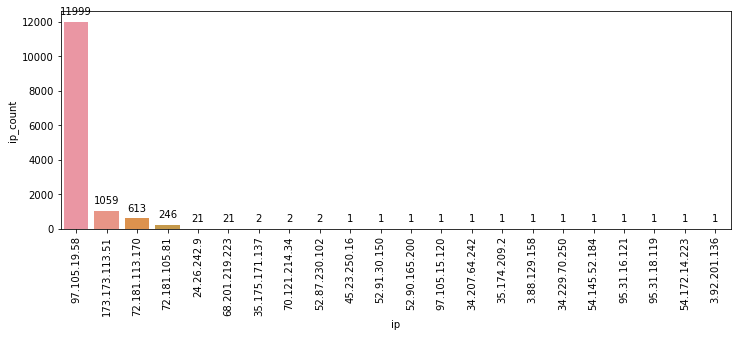

In [10]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

### Establish Baseline

In [11]:
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']
train = train[['ip','request_method','status','size','destination','request_agent','size_mb']]

### Compute probabilities based on train sample

In [12]:
ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

### Merge probabilities with all data (train + new data):

In [13]:
df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')
df.ip_proba.value_counts()

0.858595    11999
0.075784     1059
0.043867      613
0.017604      246
0.001503       42
0.000072       10
0.000143        6
0.000000        3
Name: ip_proba, dtype: int64

# Conditional Probabilities: Probabilities using 2 discrete variables

## Probability of Status given IP Address

In [14]:
ip_probs = train.groupby('ip').size().div(len(df))

status_given_ip = pd.DataFrame(train.groupby(['ip', 'status']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_ip'})
                              )

In [15]:
ip_status_count = pd.DataFrame(train.groupby(['ip', 'status'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'ip_status_count'}))


ip_status = status_given_ip.merge(ip_status_count)

## Add these probabilities to original events to detect anomalous events

In [16]:
df = df.reset_index().merge(ip_status, on=['ip', 'status'], how='left').fillna(value=0).set_index('timestamp')

In [17]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595,0.999119,11984.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595,0.999119,11984.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595,0.999119,11984.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595,0.999119,11984.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595,0.999119,11984.0


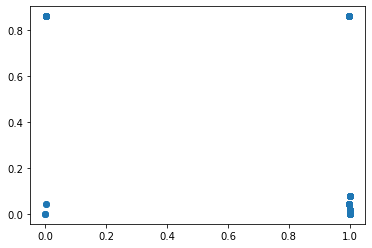

In [18]:
plt.scatter(df.proba_status_given_ip, df.ip_proba)

# Exercise

## Discrete Data + Probability

### - Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

In [19]:
# simplify and clean up request method by removing page data
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

# simplify and clean up request method by removing page data
df['request_method'] = df.request_method.str.replace(r' HTTP/1.1', '', regex=True)

# simplify and clean up request method by removing page data
df['request_method'] = df.request_method.str.replace(r'HTTP/1.1', '', regex=True)

In [20]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales,200,512495,0,python-requests/2.21.0,0.488753,0.858595,0.999119,11984.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items,200,3561,0,python-requests/2.21.0,0.003396,0.858595,0.999119,11984.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales,200,510103,0,python-requests/2.21.0,0.486472,0.858595,0.999119,11984.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales,200,510003,0,python-requests/2.21.0,0.486377,0.858595,0.999119,11984.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales,200,511963,0,python-requests/2.21.0,0.488246,0.858595,0.999119,11984.0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42 to 2019-04-19 19:42:41
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ip                     13978 non-null  object 
 1   request_method         13978 non-null  object 
 2   status                 13978 non-null  int64  
 3   size                   13978 non-null  int64  
 4   destination            13978 non-null  object 
 5   request_agent          13978 non-null  object 
 6   size_mb                13978 non-null  float64
 7   ip_proba               13978 non-null  float64
 8   proba_status_given_ip  13978 non-null  float64
 9   ip_status_count        13978 non-null  float64
dtypes: float64(4), int64(2), object(4)
memory usage: 1.2+ MB


In [22]:
df.describe()

,status,size,size_mb,ip_proba,proba_status_given_ip,ip_status_count
count,13978.000000,1.397800e+04,13978.000000,13978.000000,13978.000000,13978.000000
mean,200.356703,4.500019e+05,0.429155,0.745015,0.997785,10386.654886
std,10.182001,1.614915e+05,0.154010,0.279817,0.036773,3919.199881
min,200.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,200.000000,5.006370e+05,0.477445,0.858595,0.999119,11984.000000
50%,200.000000,5.101380e+05,0.486506,0.858595,0.999119,11984.000000
75%,200.000000,5.112910e+05,0.487605,0.858595,0.999119,11984.000000
max,499.000000,2.056327e+06,1.961066,0.858595,1.000286,11984.000000


In [23]:
df.shape

(13978, 10)

<AxesSubplot:>

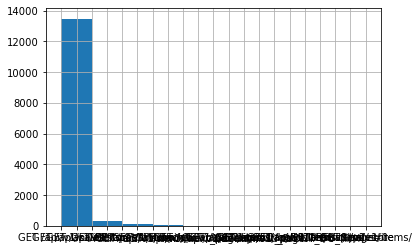

In [24]:
df.request_method.hist()

In [25]:
df.request_method.value_counts()

GET /api/v1/sales                      12403
GET /api/v1/items                       1065
GET /api/v1/stores                       229
GET /                                    107
GET /documentation                       100
GET /favicon.ico                          26
GET /api/v1//api/v1/items                 11
GET /api/v1/items/api/v1/items             7
GET /api/v1/sales/                         6
GET /api/v1/items/next_page                5
GET /api/v1/                               4
GET /api/v1/store                          3
GET /api/v1/itemsitems                     3
GET /api/v1items                           2
GET /api/V1/HiZach!                        1
GET /api/v1/helloclass!                    1
GET /api/v1//api/v1/items/next_page        1
GET /api/v1/I_DIDNT_DO_IT!!!!              1
GET /api/v1/items&page=0                   1
GET /api/v1                                1
GET /api/v1/items/                         1
Name: request_method, dtype: int64

In [26]:
ip_df = pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_method_count'})
ip_df2 = pd.DataFrame(df.request_method.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_method_proba'})
ip_df = ip_df.merge(ip_df2)


# see those where rate < 1% 
ip_df[ip_df.request_method_proba < .01]

,request_method,request_method_count,request_method_proba
3,GET /,107,0.007655
4,GET /documentation,100,0.007154
5,GET /favicon.ico,26,0.001860
6,GET /api/v1//api/v1/items,11,0.000787
7,GET /api/v1/items/api/v1/items,7,0.000501
8,GET /api/v1/sales/,6,0.000429
9,GET /api/v1/items/next_page,5,0.000358
10,GET /api/v1/,4,0.000286
11,GET /api/v1/store,3,0.000215
12,GET /api/v1/itemsitems,3,0.000215


21
                         request_method  request_method_count  \
11                    GET /api/v1/store                     3   
12               GET /api/v1/itemsitems                     3   
13                     GET /api/v1items                     2   
14                  GET /api/V1/HiZach!                     1   
15              GET /api/v1/helloclass!                     1   
16  GET /api/v1//api/v1/items/next_page                     1   
17        GET /api/v1/I_DIDNT_DO_IT!!!!                     1   
18             GET /api/v1/items&page=0                     1   
19                          GET /api/v1                     1   
20                   GET /api/v1/items/                     1   

    request_method_proba  
11              0.000215  
12              0.000215  
13              0.000143  
14              0.000072  
15              0.000072  
16              0.000072  
17              0.000072  
18              0.000072  
19              0.000072  
20         

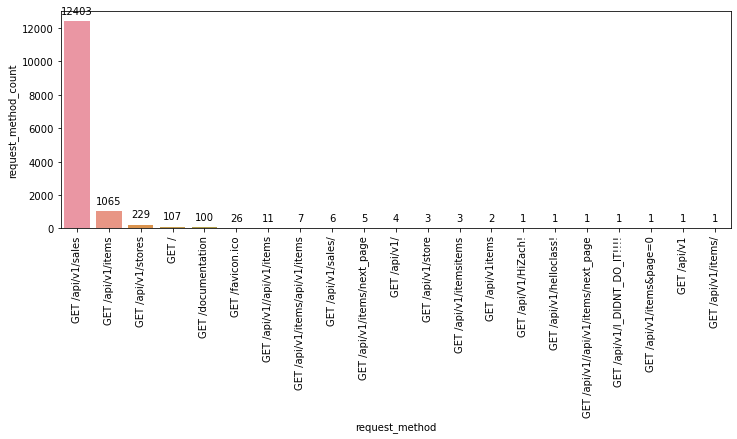

In [27]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'request_method', y = 'request_method_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

## Establish Baseline:

In [28]:
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']
train = train[['ip','request_method','status','size','destination','request_agent','size_mb']]

## Compute probabilities based on train sample:

In [29]:
ip_df = pd.DataFrame(train.request_method.value_counts(dropna=False)/train.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_method_proba'})

In [30]:
ip_df.head()

,request_method,request_method_proba
0,GET /api/v1/sales,0.887577
1,GET /api/v1/items,0.076213
2,GET /api/v1/stores,0.016388
3,GET /,0.007657
4,GET /documentation,0.007156


## Merge probabilities with all data (train + new data):

In [31]:
df = df.reset_index().merge(ip_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')
df.request_method_proba.value_counts()

0.887577    12403
0.076213     1065
0.016388      229
0.007657      107
0.007156      100
0.001861       26
0.000215       12
0.000787       11
0.000501        7
0.000072        6
0.000358        5
0.000286        4
0.000143        2
0.000000        1
Name: request_method_proba, dtype: int64

In [32]:
# value counts?
df[df['request_method_proba'] == 0]

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count,request_method_proba
timestamp,,,,,,,,,,,
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/,200,1153005,0,python-requests/2.21.0,1.099591,0.0,0.0,0.0,0.0


In [33]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count,request_method_proba
timestamp,,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales,200,512495,0,python-requests/2.21.0,0.488753,0.858595,0.999119,11984.0,0.887577
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items,200,3561,0,python-requests/2.21.0,0.003396,0.858595,0.999119,11984.0,0.076213
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales,200,510103,0,python-requests/2.21.0,0.486472,0.858595,0.999119,11984.0,0.887577
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales,200,510003,0,python-requests/2.21.0,0.486377,0.858595,0.999119,11984.0,0.887577
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales,200,511963,0,python-requests/2.21.0,0.488246,0.858595,0.999119,11984.0,0.887577


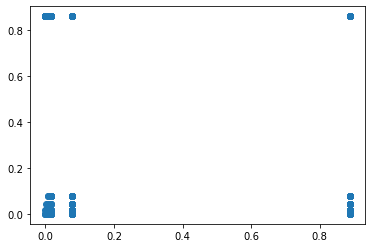

In [34]:
plt.scatter(df.request_method_proba, df.ip_proba)

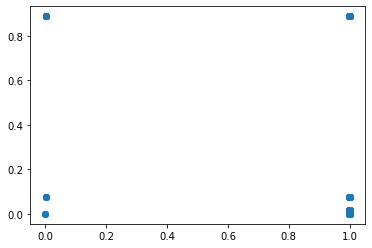

In [35]:
plt.scatter(df.proba_status_given_ip, df.request_method_proba)

In [39]:
df[(df['request_method_proba'] < 0.1) & (df['ip_proba'] < 0.1)]

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count,request_method_proba
timestamp,,,,,,,,,,,
2019-04-16 19:39:14,3.92.201.136,GET /,200,42,0,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000040,0.000072,1.000286,1.0,0.007657
2019-04-16 19:39:15,52.90.165.200,GET /favicon.ico,200,162,0,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,0.000072,1.000286,1.0,0.001861
2019-04-16 19:40:32,3.88.129.158,GET /api/v1/items,200,3561,0,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.003396,0.000072,1.000286,1.0,0.076213
2019-04-16 19:40:33,34.207.64.242,GET /favicon.ico,200,162,0,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,0.000072,1.000286,1.0,0.001861
2019-04-16 19:40:36,54.172.14.223,GET /api/v1/,200,162,0,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000154,0.000072,1.000286,1.0,0.000286
...,...,...,...,...,...,...,...,...,...,...,...
2019-04-17 06:16:10,24.26.242.9,GET /api/v1/stores,200,1328,0,python-requests/2.21.0,0.001266,0.001503,1.000286,21.0,0.016388
2019-04-17 10:25:50,45.23.250.16,GET /api/v1/stores,200,1328,0,python-requests/2.21.0,0.001266,0.000072,1.000286,1.0,0.016388
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/,200,1153005,0,python-requests/2.21.0,1.099591,0.000000,0.000000,0.0,0.000000


In [37]:
df[(df['request_method_proba'] > 0.1) & (df['proba_status_given_ip'] < 0.9)]

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count,request_method_proba
timestamp,,,,,,,,,,,
2019-04-16 19:55:15,97.105.19.58,GET /api/v1/sales,499,0,0,python-requests/2.20.1,0.0,0.858595,0.001167,14.0,0.887577
2019-04-16 19:56:02,97.105.19.58,GET /api/v1/sales,499,0,0,python-requests/2.20.1,0.0,0.858595,0.001167,14.0,0.887577
2019-04-16 20:28:46,97.105.19.58,GET /api/v1/sales,499,0,0,python-requests/2.21.0,0.0,0.858595,0.001167,14.0,0.887577
2019-04-16 20:33:24,97.105.19.58,GET /api/v1/sales,499,0,0,python-requests/2.21.0,0.0,0.858595,0.001167,14.0,0.887577
2019-04-16 20:45:28,97.105.19.58,GET /api/v1/sales,499,0,0,python-requests/2.21.0,0.0,0.858595,0.001167,14.0,0.887577
2019-04-16 21:00:35,97.105.19.58,GET /api/v1/sales,499,0,0,python-requests/2.20.1,0.0,0.858595,0.001167,14.0,0.887577
2019-04-16 21:02:07,97.105.19.58,GET /api/v1/sales,499,0,0,python-requests/2.20.1,0.0,0.858595,0.001167,14.0,0.887577
2019-04-16 21:30:46,97.105.19.58,GET /api/v1/sales,499,0,0,python-requests/2.21.0,0.0,0.858595,0.001167,14.0,0.887577
2019-04-16 21:39:21,97.105.19.58,GET /api/v1/sales,499,0,0,python-requests/2.21.0,0.0,0.858595,0.001167,14.0,0.887577
